In [130]:
from plotnine import *
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

In [131]:
SUB1GAD = 'results\subjectGAD1.csv'
SUB2GAD = 'results\subjectGAD2.csv'
SUB1SAD = 'results\subjectSAD1.csv'

sub1G = pd.read_csv(SUB1GAD)
sub2G = pd.read_csv(SUB2GAD)
sub1S = pd.read_csv(SUB1SAD)

sub1G = sub1G[sub1G['Mode'] == 'main']
sub2G = sub2G[sub2G['Mode'] == 'main']
sub1S = sub1S[sub1S['Mode'] == 'main']

In [132]:
subDics = []
for subject in [sub1G, sub2G, sub1S]:
    dic = defaultdict(list)
    lastVal = None
    lastPress = None
    delay = None
    for index, row in subject.iterrows():
        if lastVal == None:
            lastVal = row['Today']
            lastPress = row['Choice']
            delay = row['Delay']
        elif row['Choice'] != lastPress or row['Delay'] != delay or lastVal == row['Today']:
            # We moved to a different delay, a new iterating block. No value was satifactory for a change of preference
            if row['Delay'] != delay or lastVal == row['Today']:
                dic[delay].append((lastVal, lastVal))
                lastVal = row['Today']
                lastPress = row['Choice']
                delay = row['Delay']
            # There was a change in preference. The value of change is the average between the current value and the last value.
            # After that, we start a new iterating block until change, so we nullify all variables.
            # We keep tuples of the actual value and the average value so we can check temporal consistency later.
            else:
                avgVal = (row['Today'] + lastVal) / 2.0
                dic[delay].append((avgVal, row['Today']))
                lastVal = None
                lastPress = None
                delay = None
        # Still in the same iterating block so just need to save the last value.
        else:
            lastVal = row['Today']
    # We need to check that we saved the last iteration block, since it might have ended with no change of preference.
    if lastVal != None:
        dic[delay].append((lastVal, lastVal))
    subDics.append(dic)

In [133]:
subDics

[defaultdict(list,
             {0.5: [(925.0, 900), (875.0, 900)],
              36.0: [(665.5, 700), (550.0, 500)],
              300.0: [(39.5, 25), (13.0, 25)],
              12.0: [(615.5, 631), (724.0, 748)],
              3.0: [(724.0, 748), (875.0, 900)],
              6.0: [(615.5, 600), (550.0, 500)],
              60.0: [(96.5, 100), (13.0, 25)],
              0.25: [(925.0, 950), (925.0, 950)],
              120.0: [(96.5, 100), (96.5, 93)],
              1.0: [(1000, 1000), (875.0, 850)]}),
 defaultdict(list,
             {300.0: [(13.0, 25), (150.0, 100)],
              1.0: [(825.0, 800), (925.0, 950)],
              0.25: [(875.0, 900), (975.0, 1000)],
              60.0: [(550.0, 600), (615.5, 631)],
              12.0: [(450.0, 400), (550.0, 500)],
              120.0: [(550.0, 500), (665.5, 700)],
              6.0: [(825.0, 850), (13.0, 25)],
              0.5: [(975.0, 1000), (774.0, 748)],
              36.0: [(450.0, 400), (724.0, 748)],
              3.0: [(925.

In [134]:
# Remove outliers
del subDics[1][6.0][1]
del subDics[2][0.5][1]
subDics

[defaultdict(list,
             {0.5: [(925.0, 900), (875.0, 900)],
              36.0: [(665.5, 700), (550.0, 500)],
              300.0: [(39.5, 25), (13.0, 25)],
              12.0: [(615.5, 631), (724.0, 748)],
              3.0: [(724.0, 748), (875.0, 900)],
              6.0: [(615.5, 600), (550.0, 500)],
              60.0: [(96.5, 100), (13.0, 25)],
              0.25: [(925.0, 950), (925.0, 950)],
              120.0: [(96.5, 100), (96.5, 93)],
              1.0: [(1000, 1000), (875.0, 850)]}),
 defaultdict(list,
             {300.0: [(13.0, 25), (150.0, 100)],
              1.0: [(825.0, 800), (925.0, 950)],
              0.25: [(875.0, 900), (975.0, 1000)],
              60.0: [(550.0, 600), (615.5, 631)],
              12.0: [(450.0, 400), (550.0, 500)],
              120.0: [(550.0, 500), (665.5, 700)],
              6.0: [(825.0, 850)],
              0.5: [(975.0, 1000), (774.0, 748)],
              36.0: [(450.0, 400), (724.0, 748)],
              3.0: [(925.0, 950), (87

In [135]:
# Create average per subject for every delay. These are the x and y values of the graph
avgSubDics = []
def getAverage(lstOfTuples):
    averages = [elem[0] for elem in lstOfTuples]
    return sum(averages) / len(averages)
for dic in subDics:
    avgSubDics.append({k: getAverage(v) for k,v in dic.items()})
avgSubDics

[{0.5: 900.0,
  36.0: 607.75,
  300.0: 26.25,
  12.0: 669.75,
  3.0: 799.5,
  6.0: 582.75,
  60.0: 54.75,
  0.25: 925.0,
  120.0: 96.5,
  1.0: 937.5},
 {300.0: 81.5,
  1.0: 875.0,
  0.25: 925.0,
  60.0: 582.75,
  12.0: 500.0,
  120.0: 607.75,
  6.0: 825.0,
  0.5: 874.5,
  36.0: 587.0,
  3.0: 900.0},
 {300.0: 13.0,
  0.25: 975.0,
  6.0: 850.0,
  60.0: 416.0,
  12.0: 875.0,
  3.0: 824.5,
  120.0: 150.0,
  36.0: 300.0,
  0.5: 975.0,
  1.0: 975.0}]

[0.06638226 0.89991808]
0.8740867433487381


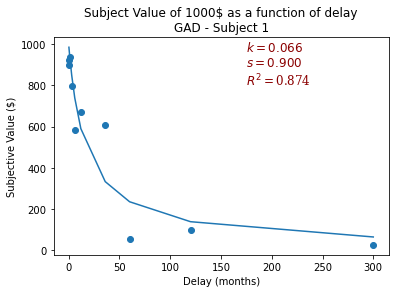

[0.3615578  0.23492136]
0.7317023901938711


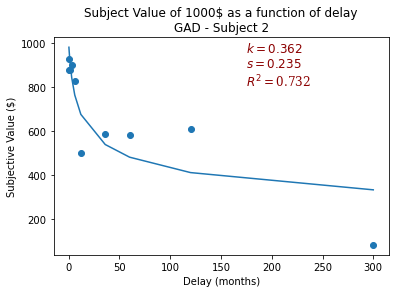

[0.01336781 1.99303451]
0.9490191015460007


<ipython-input-136-7cb4d4952603>:8: RuntimeWarning: invalid value encountered in power


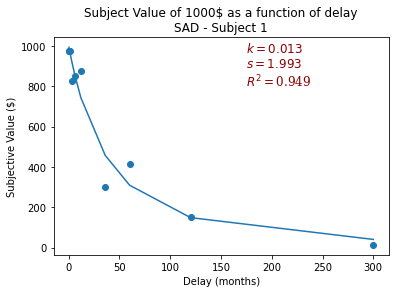

In [136]:
# Fitting curves for each subject
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }
def hyperbolaLikeFunction(delay, k, s):
    denom = pow(1+(k*delay), s)
    return 1000 / denom
guess = [0.169, 0.704]
dfs = [pd.DataFrame({'Delay (months)': dic.keys(), 'Subject Value ($)': dic.values()}) for dic in avgSubDics]
for df, title in zip(dfs, ["Subject Value of 1000$ as a function of delay\nGAD - Subject 1",
                           "Subject Value of 1000$ as a function of delay\nGAD - Subject 2",
                           "Subject Value of 1000$ as a function of delay\nSAD - Subject 1"]):
    plt.scatter(df['Delay (months)'], df['Subject Value ($)'])
    x = df.sort_values(by='Delay (months)')
    delay = x['Delay (months)'].values
    subVal = x['Subject Value ($)'].values
    c, cov = curve_fit(hyperbolaLikeFunction, delay, subVal, p0=guess)
    print(c)
    hyperbol = [ hyperbolaLikeFunction(delay[i], c[0], c[1]) for i in range(len(delay)) ]
    print(r2_score(subVal, hyperbol))
    plt.plot(delay, hyperbol)
    plt.title(title)
    plt.xlabel("Delay (months)")
    plt.ylabel("Subjective Value ($)")
    plt.text(175, 800, f"$k={c[0]:.3f}$\n$s={c[1]:.3f}$\n" + r'$R^{2}=$' + f"{r2_score(subVal, hyperbol):.3f}", fontdict=font)
    plt.show()

[0.06638226 0.89991808]
0.8740867433487381
[0.3615578  0.23492136]
0.7317023901938711
[0.01336781 1.99303451]
0.9490191015460007


<ipython-input-136-7cb4d4952603>:8: RuntimeWarning: invalid value encountered in power


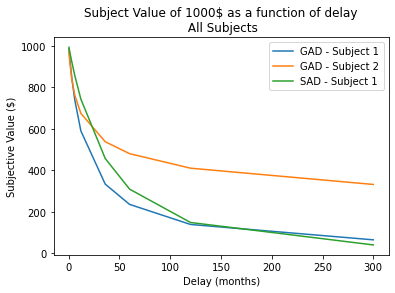

In [137]:
# Plot all fits on the same graph
for df, title in zip(dfs, ["GAD - Subject 1",
                           "GAD - Subject 2",
                           "SAD - Subject 1"]):
    x = df.sort_values(by='Delay (months)')
    delay = x['Delay (months)'].values
    subVal = x['Subject Value ($)'].values
    c, cov = curve_fit(hyperbolaLikeFunction, delay, subVal, p0=guess)
    print(c)
    hyperbol = [ hyperbolaLikeFunction(delay[i], c[0], c[1]) for i in range(len(delay)) ]
    print(r2_score(subVal, hyperbol))
    plt.plot(delay, hyperbol, label=title)
    plt.xlabel("Delay (months)")
    plt.ylabel("Subjective Value ($)")
    plt.legend()
plt.title("Subject Value of 1000$ as a function of delay\n All Subjects")
plt.show()

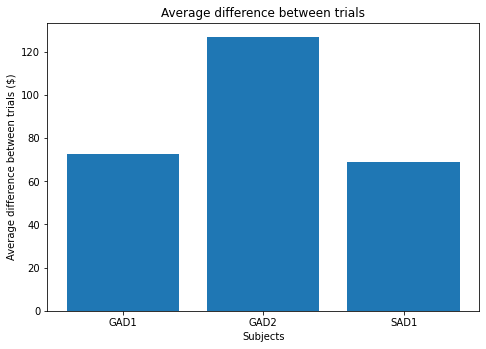

In [139]:
# Check for consistency between ascending and descending trials
avgDiffs = []
for dic in subDics:
    diffs = []
    for delay, answers in dic.items():
        if len(answers) == 1:
            continue
        diffs.append(abs(answers[0][0] - answers[1][0]))
    avgDiffs.append(np.mean(diffs))

# Create bar plot of average diffs
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
subjects = ["GAD1", "GAD2", "SAD1"]
ax.bar(subjects,avgDiffs)
plt.title("Average difference between trials")
plt.xlabel("Subjects")
plt.ylabel("Average difference between trials ($)")
plt.show()